In [1]:
import pathlib

In [2]:
import numpy as np
import torch

from residual_actions import ResidualActionsSettings, ResidualActionsLearner

# Read data

In [3]:
# TODO: more training data
with open('datasets/pendulum_expert_data/observations.npy', 'rb') as f:
    states = np.load(f, allow_pickle=True)
with open('datasets/pendulum_expert_data/actions.npy', 'rb') as f:
    actions = np.load(f, allow_pickle=True)

# skip close fromes, essentialy changing from 60 fps to 15 fps
states = states[::4, ...]
actions = actions[::4, ...]

# Set config

In [4]:
# TODO: LR scheduler
SETTINGS = ResidualActionsSettings(
    history_size=16,
    hidden_channels_memory=128,
    hidden_channels_behavior=256,
    batch_size=32,
    optim_learning_rate=0.001,
    target_loss=1e-07,
    force_stop_at_plateau_epochs=20,
    train_log_frequency=20,
    running_loss_window_size=10,
    min_epochs=100,
    grace_epochs_after_min_epochs=20,
    max_epochs=900
)

In [5]:
learner = ResidualActionsLearner(
    state_space_size=states.shape[-1],
    action_space_size=actions.shape[-1],
    settings=SETTINGS,
    device='cuda'
)

# Train

In [6]:
learner.process_and_train_full(
    states_train=torch.from_numpy(states).to(torch.float32).cuda(),
    actions_train=torch.from_numpy(actions).to(torch.float32).cuda()
)
torch.save(learner.get_state_dicts(), SETTINGS.learner_state_path)

INFO:residual_actions._res_actions_learner:ResidualActionsLearner training: epoch 20; loss: 0.28173402; running mean loss of 10 size: 0.28676241; 
additional loss info: {'memory': 0.13820220809429884, 'behavior': 0.14353182166814804}.
INFO:residual_actions._res_actions_learner:ResidualActionsLearner training: epoch 40; loss: 0.1146236; running mean loss of 10 size: 0.1621839; 
additional loss info: {'memory': 0.03237541206181049, 'behavior': 0.08224818482995033}.
INFO:residual_actions._res_actions_learner:ResidualActionsLearner training: epoch 60; loss: 0.10310176; running mean loss of 10 size: 0.1041531; 
additional loss info: {'memory': 0.022257481003180146, 'behavior': 0.0808442821726203}.
INFO:residual_actions._res_actions_learner:ResidualActionsLearner training: epoch 80; loss: 0.093619; running mean loss of 10 size: 0.09870784; 
additional loss info: {'memory': 0.010549089638516307, 'behavior': 0.0830699079670012}.
INFO:residual_actions._res_actions_learner:ResidualActionsLearner

# Evaluate

In [7]:
import gym

In [8]:
learner.set_state_dicts(torch.load(SETTINGS.learner_state_path))

In [9]:
learner.to_inplace('cpu')

In [10]:
env = gym.make('Pendulum-v1', render_mode='human')
obs, info = env.reset()
done = False

observations = []
actions = []

In [11]:
max_steps = 200
step_counter = 0
rewards = []
while not done and step_counter < max_steps:
    action = learner.act_and_step(torch.from_numpy(obs).to(torch.float32))
    obs, reward, done, terminated, info = env.step(np.array([action]))
    rewards.append(reward)
    env.render()
    step_counter += 1
    if step_counter % 20 == 0:
        print(f'step: {step_counter}')
env.close()

C:\Users\kenfir\PycharmProjects\proxymore_learners\residual_actions\residual_actions\venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


step: 20
step: 40
step: 60
step: 80
step: 100
step: 120
step: 140
step: 160
step: 180
step: 200


In [16]:
rewards_np = np.array(rewards)

In [12]:
import matplotlib.pyplot as plt

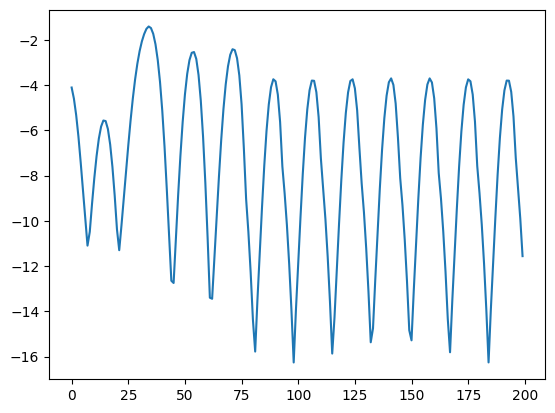

In [17]:
plt.plot(rewards_np)

In [18]:
rewards_np.max(), rewards_np.min()

(-1.4076841157685576, -16.260836211197034)